# Прогнозирование продолжительности поездки на такси

В данном проекте задача решается на основе данных одного из конкурса Kaggle (https://www.kaggle.com/competitions/nyc-taxi-trip-duration). В этом конкурсе предлагается построить модель, которая предсказывает общую продолжительность поездок на такси в Нью-Йорке. Основной набор данных - это набор данных, выпущенный Комиссией по такси и лимузинам Нью-Йорка, который включает время доставки, географические координаты, количество пассажиров и несколько других переменных.

Данные состоят из трех csv-файлов:

   ```train.csv``` - обучающая выборка (содержит 1 458 644 наблюдений)
    
   ```test.csv``` - тестовая выборка (содержит 625 134 наблюдений)

  ```sample_submission.csv``` - выборка для подтверждения решения

Тренировочный и тестовый наборы данных включают в себя следующие переменные: 

* ```id``` - уникальный идентификатор для каждой поездки

* ```vendor_id``` -код, указывающий поставщика услуг, связанного с записью о поездке

* ```pickup_datetime``` - дата и время, когда счетчик был включен

* ```dropoff_datetime``` - дата и время, когда счетчик был отключен

* ```passenger_count``` - количество пассажиров в транспортном средстве (введенное водителем значение)

* ```pickup_longitude``` - долгота, на которой был включен счетчик

* ``pickup_latitude`` - широта, на которой был включен счетчик

* ```dropoff_longitude``` - долгота, на которой счетчик был отключен

* ```dropoff_latitude``` - широта, на которой счетчик был отключен

* ```store_and_fwd_flag``` - эта переменная указывает, сохранялась ли запись о поездке в памяти транспортного средства перед отправкой поставщику, поскольку у транспортного средства не было подключения к серверу (Y = сохранить и переслать; N = не хранить и не пересылать поездку)

* ```trip_duration``` - продолжительность поездки в секундах

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')

sns.set(rc={"figure.figsize":(8, 5)})

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_data = pd.read_csv("/content/gdrive/My Drive/Taxi_duration_prediction/train.csv")
test_data = pd.read_csv("/content/gdrive/My Drive/Taxi_duration_prediction/test.csv")

In [ ]:
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [ ]:
train_data.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [ ]:
round(train_data[["passenger_count", "trip_duration"]].describe(), 2)

,passenger_count,trip_duration
count,1458644.00,1458644.00
mean,1.66,959.49
std,1.31,5237.43
min,0.00,1.00
25%,1.00,397.00
50%,1.00,662.00
75%,2.00,1075.00
max,9.00,3526282.00


In [ ]:
train_data.vendor_id.value_counts(normalize=True)

2    0.53495
1    0.46505
Name: vendor_id, dtype: float64

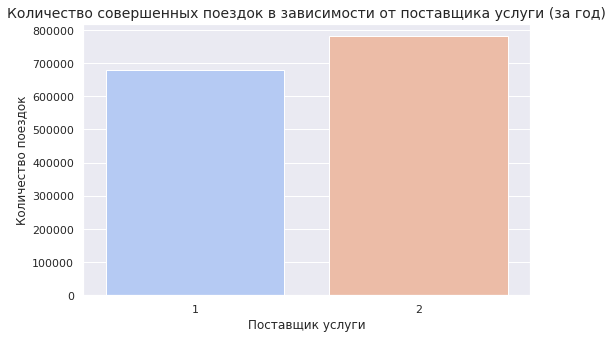

In [ ]:
sns.countplot(x = train_data.vendor_id, palette = "coolwarm")
plt.title("Количество совершенных поездок в зависимости от поставщика услуги (за год)", fontsize=14)
plt.xlabel("Поставщик услуги")
plt.ylabel("Количество поездок")
plt.show()

In [ ]:
round(train_data.passenger_count.value_counts(normalize=True),2)

1    0.71
2    0.14
5    0.05
3    0.04
6    0.03
4    0.02
0    0.00
7    0.00
9    0.00
8    0.00
Name: passenger_count, dtype: float64

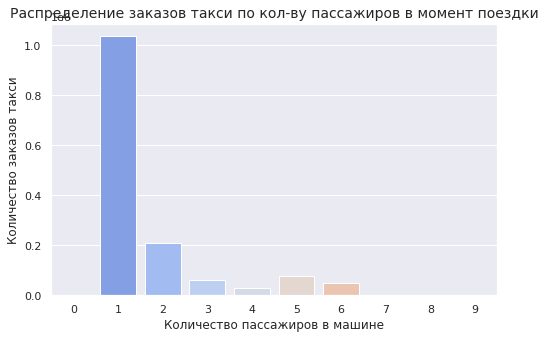

In [ ]:
sns.countplot(x = train_data.passenger_count, palette = "coolwarm")
plt.title("Распределение заказов такси по кол-ву пассажиров в момент поездки", fontsize=14)
plt.xlabel("Количество пассажиров в машине")
plt.ylabel("Количество заказов такси")
plt.show()

Чаще всего в транспортном средстве в момент поездки едут 1-2 пассажира. 

### 2. Предобработка данных тренировочной выборки

#### 2.1 Продолжительность поездки

При изучении описательных статистик переменных было сделано предположение о наличии выбросов в таргете - продолжительности поездки. Одним из простейших методов обнаружения выбросов является использование графиков типа *box plot*. 

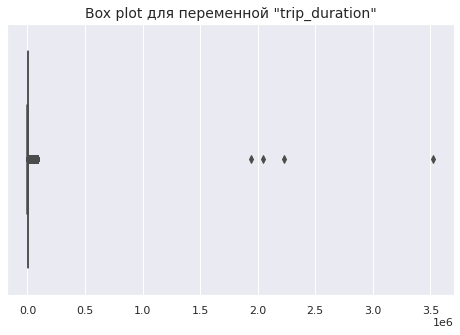

In [ ]:
sns.boxplot(train_data["trip_duration"].values)
plt.title("Box plot для переменной \"trip_duration\"", fontsize=14)
plt.show()

График однозначно подтверждает наличие выбросов в данных по рассматриваемой переменной.  
Большинство алгоритмов машинного обучения плохо работают с выбросами, поэтому их необходимо удалять.

Одним из способов решения проблемы выбросов является их исключение. Например, можно исключить наблюдения с такими значеними продолжительности поездки, которые превышают значения, находящиеся за пределами +- 1.5 интерквантильных размаха от первого и третьего квартилей.

In [ ]:
iqr = 1.5 * (np.quantile(train_data["trip_duration"], 0.75) - np.quantile(train_data["trip_duration"], 0.25))
lower_tail = np.quantile(train_data["trip_duration"], 0.25) - iqr
upper_tail = np.quantile(train_data["trip_duration"], 0.75) + iqr

In [ ]:
len(train_data[train_data["trip_duration"] > upper_tail])

74220

In [ ]:
upper_tail/60

34.86666666666667

В случае использования данного подхода мы можем потерять большое количество наблюдений, в которых длительность поездки превышает 35 минут. В результате, алгоритм будет плохо справляться с прогнозированием длительных поездок.

Другим возможным вариантом решения проблемы с выбросами может стать исключение данных, которые находятся за пределами 2 стандартных отклонений от среднего значения.

In [ ]:
duration_mean = np.mean(train_data['trip_duration'])
duration_std = np.std(train_data['trip_duration'])
len(train_data[train_data['trip_duration'] >= duration_mean + 2*duration_std])

2104

In [ ]:
(duration_mean + 2*duration_std)/60

190.5725355223024

В таком случае мы исключим только 2104 наблюдений, а в тренеровочной выборке останутся поездки длительностью до 190 минут. 

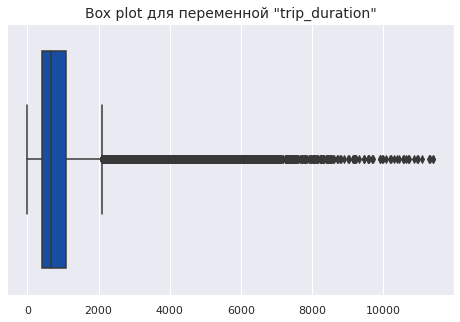

In [ ]:
sns.boxplot(train_data[train_data['trip_duration'] <= duration_mean + 2*duration_std]['trip_duration'].values, 
            color = "#0048ba")
plt.title("Box plot для переменной \"trip_duration\"", fontsize=14)
plt.show()

Исключение наблюдений, находящихся за пределеами двух стандартных отклонений от среднего переменной длительности поездки, немного улучшает распределение данных, но при этом мы видим, что большое количество значений, значительно отличающихся от медианы, присутствует в данных. 

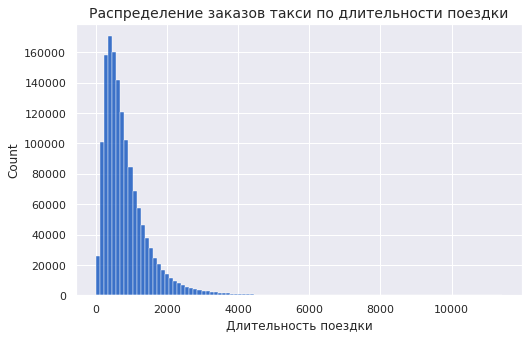

In [ ]:
sns.histplot(x = train_data[train_data.trip_duration <= duration_mean + 2*duration_std]["trip_duration"].values, 
             bins = 100, color = "#0048ba")
plt.title("Распределение заказов такси по длительности поездки", fontsize=14)
plt.xlabel("Длительность поездки")
plt.show()

Кроме того, к данным можно применить некоторые другие трансформации для того, чтобы выявить определенные паттерны или же добиться более эффективной работы применяемого алгоритма в дальнейшем. Одной из стандартных трансформаций является логарифмирование переменной. Ниже представлено распределение таргета - продолжительности поездки - без удаления выбросов. 

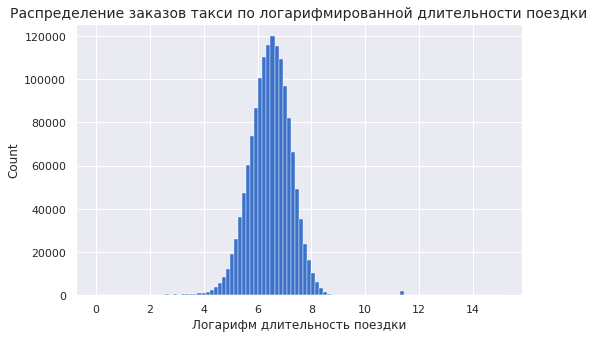

In [ ]:
sns.histplot(x = np.log(train_data["trip_duration"]).values, bins=100, color = "#0048ba")
plt.title("Распределение заказов такси по логарифмированной длительности поездки", fontsize=14)
plt.xlabel("Логарифм длительность поездки")
plt.show()

Логарифмирование таргета без выбросов, превышающих 2 стандартных отклонения. 

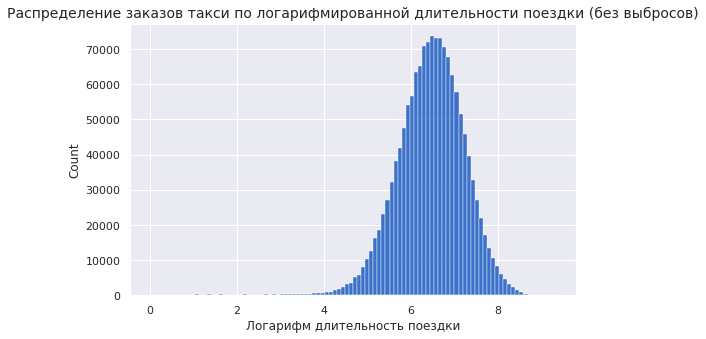

In [ ]:
sns.histplot(x = np.log(train_data[train_data.trip_duration <= duration_mean + 2*duration_std]["trip_duration"]).values, 
             bins=100, color = "#0048ba")
plt.title("Распределение заказов такси по логарифмированной длительности поездки (без выбросов)", fontsize=14)
plt.xlabel("Логарифм длительность поездки")
plt.show()

Кроме того, есть смысл посмотреть на распределение средней продолжительности поездки по конкретным датам. 

Добавим дамми-переменную, которая отражает, относится ли день к праздничному или нет.

In [ ]:
from datetime import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar

In [ ]:
train_data["date"] = train_data["pickup_datetime"].apply(lambda x: datetime.strptime(x[:10], '%Y-%m-%d'))

In [ ]:
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays()

In [ ]:
train_data["holiday_date"] = train_data["date"].isin(holidays)
train_data["holiday_date"] = train_data["holiday_date"].map(lambda x: 1 if x == True else 0)

Извлечем из переменной ```pickup_datetime``` день (в году), месяц, день недели и час поездки.

In [ ]:
train_data["pickup_datetime"] = pd.to_datetime(train_data["pickup_datetime"])

train_data["pickup_date"] = train_data["pickup_datetime"].dt.date
train_data["pickup_day"] = train_data["pickup_datetime"].dt.day
train_data["pickup_month"] = train_data["pickup_datetime"].dt.month
train_data["pickup_weekday"] = train_data["pickup_datetime"].dt.weekday
train_data["pickup_hour"] = train_data["pickup_datetime"].dt.hour

Посмотрим на распределение средней продолжительности поездки по конкретным датам. 

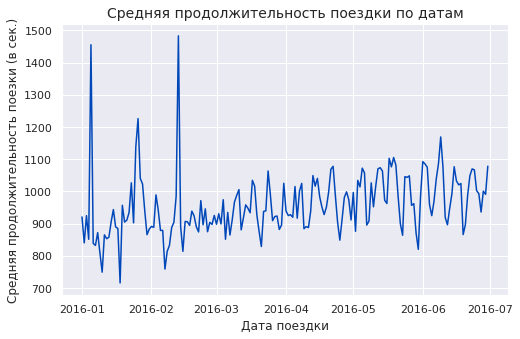

In [ ]:
sns.lineplot(x = train_data.groupby("pickup_date")["trip_duration"].mean().index , 
             y = train_data.groupby("pickup_date")["trip_duration"].mean(), color = "#0048ba")
plt.xlabel("Дата поездки")
plt.ylabel("Средняя продолжительность поезки (в сек.)")
plt.title("Средняя продолжительность поездки по датам", fontsize = 14)
plt.show()

Как видно из графика, в 2016 году было как минимум три дня с пиковыми значениями средней продолжительности поездки. 

In [ ]:
mean_taxi_duration_until_march = train_data[train_data["pickup_datetime"] < '2016-03-01 00:00:00']\
        .groupby(train_data["pickup_datetime"].dt.date)["trip_duration"].mean() 

In [ ]:
mean_taxi_duration_until_march[mean_taxi_duration_until_march.values > 1000]

pickup_datetime
2016-01-05    1455.344808
2016-01-23    1026.549757
2016-01-25    1138.146121
2016-01-26    1226.126063
2016-01-27    1040.240259
2016-01-28    1023.078354
2016-02-13    1482.958105
Name: trip_duration, dtype: float64

Пиковые значения средней продожительности поездки пришлись на 5, 25 и 26 января, 13 февраля 2016. На данном этапе непонятно, с чем могут быть связаны подобные отклонения. Стоит посмотреть среднюю продолжительности поездок в разбивке по поставщикам услуг. 

In [ ]:
mean_taxi_duration = train_data.groupby(["pickup_date", "vendor_id"])["trip_duration"].mean().reset_index()

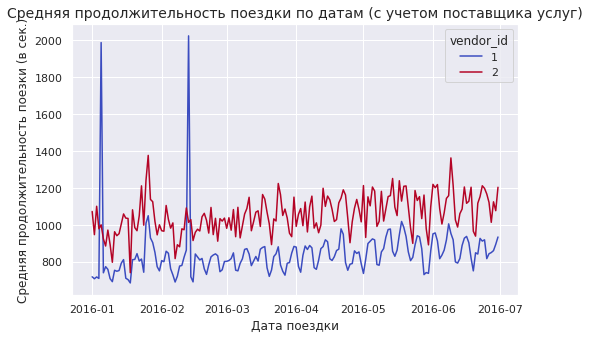

In [ ]:
sns.lineplot(x = mean_taxi_duration.pickup_date, y = mean_taxi_duration.trip_duration, 
             hue = mean_taxi_duration.vendor_id, palette = "coolwarm")
plt.xlabel("Дата поездки")
plt.ylabel("Средняя продолжительность поезки (в сек.)")
plt.title("Средняя продолжительность поездки по датам (с учетом поставщика услуг)", fontsize = 14)
plt.show()

Поездки, совершенные вторым поставщиком услуг такси, в среднем длятся чуть дольше, чем поездки, совершенные первым поставщиком.  
Кроме того, мы видим, что пиковые значения продолжительности поездок 5 января и 13 февраля относятся к поездкам, осуществленным поставщиком услуг №1. Проанализируем характеистики всех поездок у данного поставщика в эти дни. 

In [ ]:
train_data[(train_data["pickup_date"] == datetime.strptime('2016-01-05', '%Y-%m-%d').date()) &
           (train_data["vendor_id"] == 1)].sort_values(by="trip_duration", ascending=False).head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,date,holiday_date,pickup_date,pickup_day,pickup_month,pickup_weekday,pickup_hour
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,2227612,2016-01-05,0,2016-01-05,5,1,1,6
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,1939736,2016-01-05,0,2016-01-05,5,1,1,0
1411777,id3687184,1,2016-01-05 07:48:21,2016-01-05 09:11:18,2,-73.782028,40.644688,-73.980240,40.752560,Y,4977,2016-01-05,0,2016-01-05,5,1,1,7
661733,id2652444,1,2016-01-05 20:49:39,2016-01-05 22:11:07,2,-73.970078,40.693111,-73.905273,40.666233,N,4888,2016-01-05,0,2016-01-05,5,1,1,20
234830,id0232860,1,2016-01-05 08:34:16,2016-01-05 09:51:46,1,-73.778572,40.646702,-73.976097,40.756992,N,4650,2016-01-05,0,2016-01-05,5,1,1,8


In [ ]:
train_data[(train_data["pickup_date"] == datetime.strptime('2016-02-13', '%Y-%m-%d').date()) &
           (train_data["vendor_id"] == 1)].sort_values(by="trip_duration", ascending=False).head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,date,holiday_date,pickup_date,pickup_day,pickup_month,pickup_weekday,pickup_hour
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282,2016-02-13,0,2016-02-13,13,2,5,22
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,2049578,2016-02-13,0,2016-02-13,13,2,5,22
315020,id3439031,1,2016-02-13 19:30:18,2016-02-13 20:43:02,4,-73.981392,40.780392,-73.885704,40.662041,N,4364,2016-02-13,0,2016-02-13,13,2,5,19
826030,id1625923,1,2016-02-13 21:06:32,2016-02-13 22:18:56,3,-73.994850,40.750240,-73.908119,40.662651,N,4344,2016-02-13,0,2016-02-13,13,2,5,21
1251557,id2552614,1,2016-02-13 18:02:51,2016-02-13 19:12:48,2,-73.776680,40.645363,-73.928345,40.660477,N,4197,2016-02-13,0,2016-02-13,13,2,5,18


Судя по данным, пики на графиках средней продолжительности поездок возникли из-за четырех выбросов данных (2 выброса 5 января и 2 других 13 февраля), которые, скорее всего, возникли по техническим причинам и не имеют какого-либо значимого объяснения. 

In [ ]:
mean_taxi_duration_without_outliers = train_data[train_data.trip_duration < 1939736]\
                .groupby(["pickup_date", "vendor_id"])["trip_duration"].mean().reset_index()

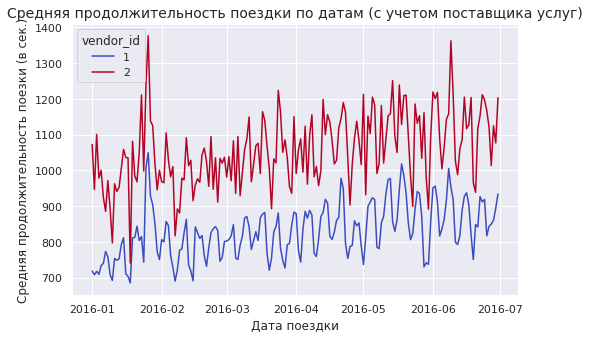

In [ ]:
sns.lineplot(x = mean_taxi_duration_without_outliers.pickup_date, 
             y = mean_taxi_duration_without_outliers.trip_duration, 
             hue = mean_taxi_duration_without_outliers.vendor_id, 
            palette = "coolwarm")
plt.xlabel("Дата поездки")
plt.ylabel("Средняя продолжительность поезки (в сек.)")
plt.title("Средняя продолжительность поездки по датам (с учетом поставщика услуг)", fontsize = 14)
plt.show()

После удаления этих четырех выбросов мы видим, что нет никаких необычных отклонений средней продолжительности поездки на такси 5 января и 13 февраля. Однако мы все еще можем наблюдать пиковые значения в конце января, а также в середине июня. 

In [ ]:
train_data[(train_data["pickup_date"] == datetime.strptime('2016-01-26', '%Y-%m-%d').date()) &
           (train_data["vendor_id"] == 1)].sort_values(by="trip_duration", ascending=False).head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,date,holiday_date,pickup_date,pickup_day,pickup_month,pickup_weekday,pickup_hour
994380,id2388206,1,2016-01-26 16:32:34,2016-01-26 19:40:49,1,-73.987244,40.721596,-73.991798,40.766392,N,11295,2016-01-26,0,2016-01-26,26,1,1,16
936006,id2510396,1,2016-01-26 06:58:16,2016-01-26 10:01:01,2,-73.789886,40.646503,-74.458847,40.797791,N,10965,2016-01-26,0,2016-01-26,26,1,1,6
1376843,id0911694,1,2016-01-26 11:07:01,2016-01-26 13:09:48,1,-73.873039,40.774006,-73.986786,40.759220,N,7367,2016-01-26,0,2016-01-26,26,1,1,11
547849,id0847664,1,2016-01-26 09:20:56,2016-01-26 10:59:01,1,-73.874573,40.774120,-74.010071,40.720863,N,5885,2016-01-26,0,2016-01-26,26,1,1,9
628903,id1557817,1,2016-01-26 15:52:34,2016-01-26 17:25:16,1,-73.998550,40.719837,-73.786743,40.644604,N,5562,2016-01-26,0,2016-01-26,26,1,1,15


In [ ]:
train_data[(train_data["pickup_date"] == datetime.strptime('2016-01-26', '%Y-%m-%d').date()) &
           (train_data["vendor_id"] == 2)].sort_values(by="trip_duration", ascending=False).head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,date,holiday_date,pickup_date,pickup_day,pickup_month,pickup_weekday,pickup_hour
901674,id2175982,2,2016-01-26 21:44:50,2016-01-27 21:43:51,1,-73.991493,40.750252,-73.997826,40.763184,N,86341,2016-01-26,0,2016-01-26,26,1,1,21
1303635,id2352519,2,2016-01-26 14:55:29,2016-01-27 14:54:14,1,-73.995789,40.759563,-74.000786,40.758217,N,86325,2016-01-26,0,2016-01-26,26,1,1,14
737219,id3147779,2,2016-01-26 14:31:18,2016-01-27 14:29:39,3,-73.968498,40.754681,-73.973000,40.746902,N,86301,2016-01-26,0,2016-01-26,26,1,1,14
857073,id1500568,2,2016-01-26 12:33:52,2016-01-27 12:31:59,2,-74.000160,40.734730,-73.981888,40.765980,N,86287,2016-01-26,0,2016-01-26,26,1,1,12
83190,id1717926,2,2016-01-26 18:59:30,2016-01-27 18:56:05,1,-73.955460,40.765244,-73.968445,40.770504,N,86195,2016-01-26,0,2016-01-26,26,1,1,18


In [ ]:
train_data[(train_data["pickup_datetime"] > '2016-06-01 00:00:00') & (train_data["vendor_id"] == 2)]\
        .groupby(train_data["pickup_datetime"].dt.date)["trip_duration"].mean()

pickup_datetime
2016-06-01    1219.218668
2016-06-02    1200.701639
2016-06-03    1218.152282
2016-06-04    1087.373424
2016-06-05    1004.184046
2016-06-06    1064.816662
2016-06-07    1142.929962
2016-06-08    1157.985466
2016-06-09    1362.400000
2016-06-10    1213.614917
2016-06-11    1026.564239
2016-06-12     987.739809
2016-06-13    1060.395166
2016-06-14    1085.362094
2016-06-15    1204.954282
2016-06-16    1116.514952
2016-06-17    1127.627940
2016-06-18    1203.790311
2016-06-19     965.113606
2016-06-20     938.605214
2016-06-21    1117.189274
2016-06-22    1152.612773
2016-06-23    1211.526967
2016-06-24    1197.399954
2016-06-25    1166.957668
2016-06-26    1121.344628
2016-06-27    1013.475286
2016-06-28    1124.538761
2016-06-29    1076.464436
2016-06-30    1203.372139
Name: trip_duration, dtype: float64

In [ ]:
train_data[(train_data["pickup_date"] == datetime.strptime('2016-06-09', '%Y-%m-%d').date()) &
           (train_data["vendor_id"] == 2)].sort_values(by="trip_duration", ascending=False).head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,date,holiday_date,pickup_date,pickup_day,pickup_month,pickup_weekday,pickup_hour
1298124,id0814936,2,2016-06-09 20:52:30,2016-06-10 20:51:43,6,-74.005936,40.736198,-73.994583,40.750385,N,86353,2016-06-09,0,2016-06-09,9,6,3,20
1331833,id1977056,2,2016-06-09 20:35:25,2016-06-10 20:33:48,1,-73.974289,40.750954,-73.985229,40.738815,N,86303,2016-06-09,0,2016-06-09,9,6,3,20
1000636,id3590479,2,2016-06-09 09:00:51,2016-06-10 08:58:56,1,-73.999161,40.734013,-74.003326,40.753139,N,86285,2016-06-09,0,2016-06-09,9,6,3,9
1067879,id3134989,2,2016-06-09 18:29:03,2016-06-10 18:26:34,1,-73.988304,40.759274,-73.969063,40.764183,N,86251,2016-06-09,0,2016-06-09,9,6,3,18
904738,id2003511,2,2016-06-09 20:30:01,2016-06-10 20:27:10,1,-74.013557,40.714394,-73.948326,40.623749,N,86229,2016-06-09,0,2016-06-09,9,6,3,20


В рассматриваемые дни есть наблюдения, в которых продолжительность поездки превышает 80000 секунд, что составляет примерно целые сутки. При этом, если смотреть на количество поездок, где продолжительность превышает данное значение, то можно увидеть, что каждый месяц подобных поездок в данных есть примерно равное количество. Больше всего таких поездок было в марте, однако на графике значения средней продолжительности поездок в марте не сильно выделяются на фоне остальных месяцев. 

In [ ]:
train_data[train_data.trip_duration > 80000].groupby("pickup_month")["trip_duration"].count()

pickup_month
1    287
2    294
3    344
4    323
5    326
6    325
Name: trip_duration, dtype: int64

In [ ]:
len(train_data[train_data.trip_duration > 80000])/len(train_data)

0.0013018940879337248

Всего же в данных поездок продольжительностью больше 80000 секунд чуть больше 0.1 процента, поэтому, возможно, при моделировании в дальнейшем стоит просто избавиться от таких наблюдений. 

#### 2.2. Количество поездок

Стоит также проанализировать количество поездок по датам. 

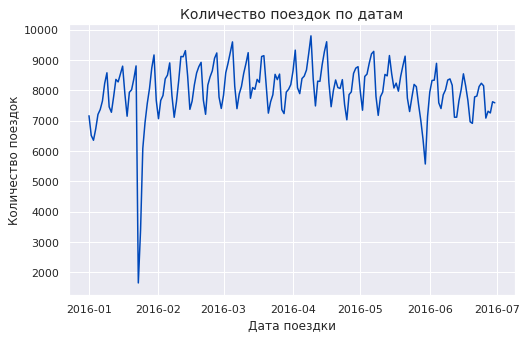

In [ ]:
sns.lineplot(x = train_data.groupby("pickup_date")["trip_duration"].count().index, 
             y = train_data.groupby("pickup_date")["trip_duration"].count(), color = "#0048ba")
plt.xlabel("Дата поездки")
plt.ylabel("Количество поездок")
plt.title("Количество поездок по датам", fontsize = 14)
plt.show()

Из графика видно, что есть два провала в количестве поездок в конце января и конце мая. 

In [ ]:
train_data[train_data.pickup_datetime < '2016-02-01 00:00:00'].groupby("pickup_date")["trip_duration"].count()

pickup_date
2016-01-01    7162
2016-01-02    6512
2016-01-03    6353
2016-01-04    6725
2016-01-05    7204
2016-01-06    7365
2016-01-07    7649
2016-01-08    8229
2016-01-09    8578
2016-01-10    7454
2016-01-11    7276
2016-01-12    7794
2016-01-13    8360
2016-01-14    8277
2016-01-15    8539
2016-01-16    8797
2016-01-17    7891
2016-01-18    7146
2016-01-19    7934
2016-01-20    8018
2016-01-21    8375
2016-01-22    8805
2016-01-23    1648
2016-01-24    3383
2016-01-25    6084
2016-01-26    6941
2016-01-27    7571
2016-01-28    8066
2016-01-29    8735
2016-01-30    9166
2016-01-31    7670
Name: trip_duration, dtype: int64

In [ ]:
train_data[(train_data.pickup_datetime > '2016-05-01 00:00:00') & (train_data.pickup_datetime < '2016-06-01 00:00:00')]\
.groupby("pickup_date")["trip_duration"].count()

pickup_date
2016-05-01    7964
2016-05-02    7344
2016-05-03    8457
2016-05-04    8535
2016-05-05    8896
2016-05-06    9202
2016-05-07    9285
2016-05-08    7801
2016-05-09    7174
2016-05-10    7789
2016-05-11    7941
2016-05-12    8524
2016-05-13    8476
2016-05-14    9147
2016-05-15    8547
2016-05-16    8077
2016-05-17    8237
2016-05-18    7971
2016-05-19    8455
2016-05-20    8808
2016-05-21    9127
2016-05-22    7745
2016-05-23    7300
2016-05-24    7762
2016-05-25    8195
2016-05-26    8121
2016-05-27    7530
2016-05-28    7004
2016-05-29    6372
2016-05-30    5570
2016-05-31    7131
Name: trip_duration, dtype: int64

Можно обнаружить, что 23 января было совершено всего 1648 поездок, когда среднее количество поездок в день в январе превышает 7000, а 30 мая было совершено 5570 поездок при среднем количестве больше 8000 в этом месяце. При этом из графика ниже заметно, что сокращение количества не зависит от поставщика услуг, а обусловлено какими-то внешними причинами. Возможно, в эти дни произошли какие-либо технические сбои, которые не позволили зафиксировать все совершившиеся поездки. 

In [ ]:
number_trips_by_vendor = train_data.groupby(["pickup_date", "vendor_id"])["trip_duration"].count().reset_index()\
                            .rename(columns = {"trip_duration": "trips_count"})

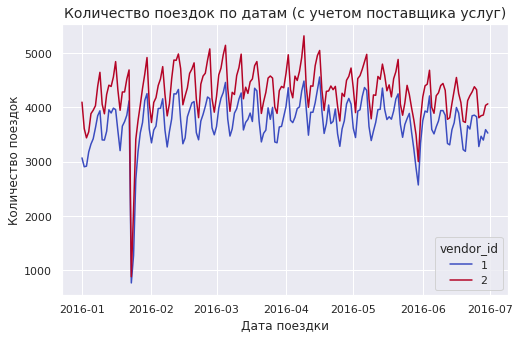

In [ ]:
sns.lineplot(x = number_trips_by_vendor.pickup_date,
             y = number_trips_by_vendor.trips_count, 
             hue = number_trips_by_vendor.vendor_id,
            palette = "coolwarm")
plt.xlabel("Дата поездки")
plt.ylabel("Количество поездок")
plt.title("Количество поездок по датам (с учетом поставщика услуг)", fontsize = 14)
plt.show()

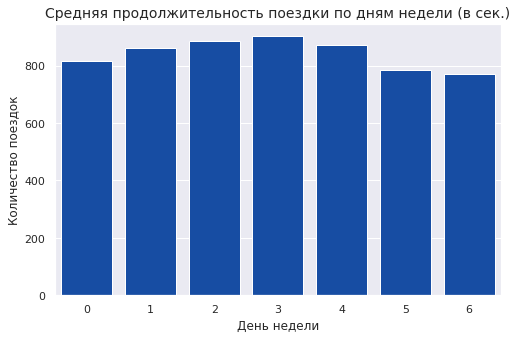

In [ ]:
sns.barplot(x = train_data[train_data.trip_duration < 80000].groupby("pickup_weekday")["trip_duration"].mean().index, 
           y = train_data[train_data.trip_duration < 80000].groupby("pickup_weekday")["trip_duration"].mean().values,
           color = "#0048ba")
plt.title("Средняя продолжительность поездки по дням недели (в сек.)", fontsize=14)
plt.xlabel("День недели")
plt.ylabel("Количество поездок")
plt.show()

Средняя продолжительность поездки в будние дни в середине неделе больше, чем в другие дни и выходные. Это логично, поскольку в будние дни загруженность дорог выше, чем в выходные. 

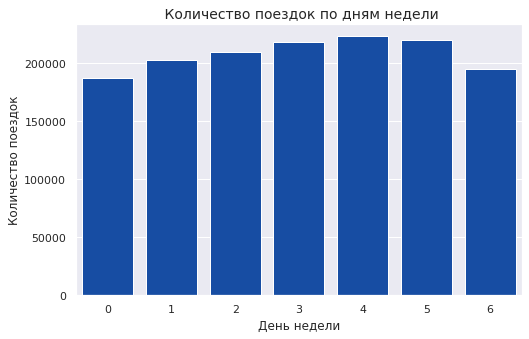

In [ ]:
sns.barplot(x = train_data[train_data.trip_duration < 80000].groupby("pickup_weekday")["trip_duration"].count().index, 
            y = train_data[train_data.trip_duration < 80000].groupby("pickup_weekday")["trip_duration"].count().values,
            color = "#0048ba")
plt.title(" Количество поездок по дням недели", fontsize=14)
plt.xlabel("День недели")
plt.ylabel("Количество поездок")
plt.show()

В течение недели количество поездок постепенно растет, достигая пика в пятницу-субботу, а затем опускаясь на минимальные значения в воскресенье-понедельник.

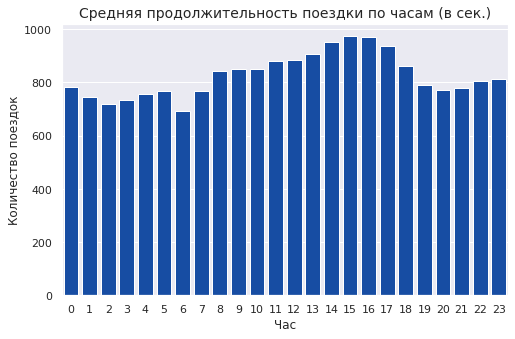

In [ ]:
sns.barplot( x = train_data[train_data.trip_duration < 80000].groupby("pickup_hour")["trip_duration"].mean().index,
             y = train_data[train_data.trip_duration < 80000].groupby("pickup_hour")["trip_duration"].mean().values,
             color = "#0048ba")
plt.title("Средняя продолжительность поездки по часам (в сек.)", fontsize=14)
plt.xlabel("Час")
plt.ylabel("Количество поездок")
plt.show()

В дневные часы средняя продолжительность поездки выше, чем в вечерние и ночные, что так же может быть объяснено уровнем загруженности дорог.

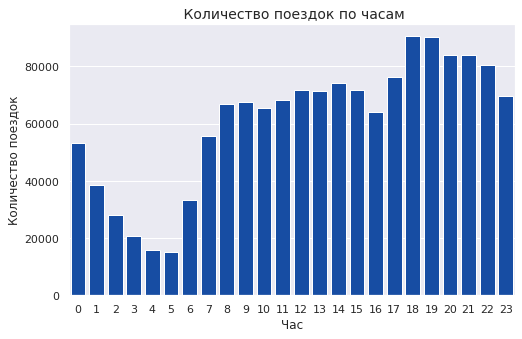

In [ ]:
sns.barplot(x = train_data[train_data.trip_duration < 80000].groupby("pickup_hour")["trip_duration"].count().index, 
            y = train_data[train_data.trip_duration < 80000].groupby("pickup_hour")["trip_duration"].count().values,
            color = "#0048ba")
plt.title(" Количество поездок по часам", fontsize=14)
plt.xlabel("Час")
plt.ylabel("Количество поездок")
plt.show()

В ночное время количество поездок минимально, в дневные часы их совершается гораздо больше, а пик поездок приходится на вечернее время в перид примерно с 18 до 21 часа. 

#### 2.3. Расстояние поездки и кластеры

Для прогнозирования длительности поездки помимо тех переменнных, которые были проанализированы выше, важной переменной так же может быть расстояние, которое проезжает такси от точки отправления в точку назначения. Мы можем определить расстояние и направление конкретной поездки на основе координат точки отправления и точки назначения поездки такси. Наиболее подходящей метрикой расстояния для геопространственных данных является расстояние гаверсинус, которое представляет собой расстояние по большой окружности между двумя точками на сфере, рассчитанное на основе их долготы и широты. 

**Haversine distance:**
$$
D(x, y) = 2arcsin\sqrt{sin^{2}((x1 - y1)/2) + cos(x1)cos(y1)sin^{2}((x2 - y2)/2)}
$$

In [ ]:
def haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # в км
    dlat = lat2 - lat1
    dlng = lng2 - lng1
    d = np.sin(dlat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_distance(lat1, lng1, lat1, lng2) #рассчитываем расстояние по долготе, как если бы широта была равна 0
    b = haversine_distance(lat1, lng1, lat2, lng1) #рассчитываем расстояние по широте, как если бы долгота была равна 0 
    return a + b

def bearing(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  
    delta_lng_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(delta_lng_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(delta_lng_rad)
    return (np.degrees(np.arctan2(y, x)) + 360) % 360

Помимо расстояния гаверсинус, с помощью второй функции выше можно рассчитать манхэттеновское расстояние, используя функцию расстояния гаверсинус. В этом случае сначала рассчитываются расстояния по широте и долготе отдельно. Для этого мы получаем расстояние по широте, как если бы долгота была равна 0, а также рассчитываем растояние по долготе, как если бы широта была равна 0. Затем складываем эти два расстояния. 

Кромер того, третья функция позволяет вычислить направление (или азимут) пройденного расстояния. Азимут может быть определен как направление или угол между линией земли с севера на юг или меридианом и линией, соединяющей конечную и изначальную точку.

Направление (азимут) из точки A в точку B (в градусах) может быть рассчитано как,

$$ 
β = atan2(Х, У)
$$ 
где, $X$ и $Y$ - две величины и могут быть рассчитаны как:
$$
X = sin( \Delta lng) * cos (lat2)
$$

$$
Y = cos(lat1) * sin(lat2) - sin(lat1) * cos(lat2) * cos( \Delta lng)
$$

Например, азимут между точками A и B, равный 95 градусам означает, что, если из точки A мы будем двигаться по азимуту 95, мы достигнем точки B.

In [ ]:
train_data["haversine_distance"] = haversine_distance(train_data["pickup_latitude"].values, 
                                                     train_data["pickup_longitude"].values, 
                                                     train_data["dropoff_latitude"].values, 
                                                     train_data["dropoff_longitude"].values)

train_data["manhattan_distance"] =  manhattan_distance(train_data["pickup_latitude"].values, 
                                                                   train_data["pickup_longitude"].values, 
                                                                   train_data["dropoff_latitude"].values, 
                                                                   train_data["dropoff_longitude"].values)

train_data["direction"] = bearing(train_data["pickup_latitude"].values, 
                                        train_data["pickup_longitude"].values, 
                                        train_data["dropoff_latitude"].values, 
                                        train_data["dropoff_longitude"].values)

Далее создадим переменную для отдельных районов города. Данную задачу можно решить с помощью простого алгоритма кластеризации KMeans.

Для отображения точек отправления такси и отдельных кластеров на графиках стоит ограничить диапазон значений широты и долготы, потому что есть несколько наблюдений, которые находятся далеко за пределами Нью-Йорка.

In [ ]:
city_long_borders = (-74.1, -73.7)
city_lat_borders = (40.6, 40.9)

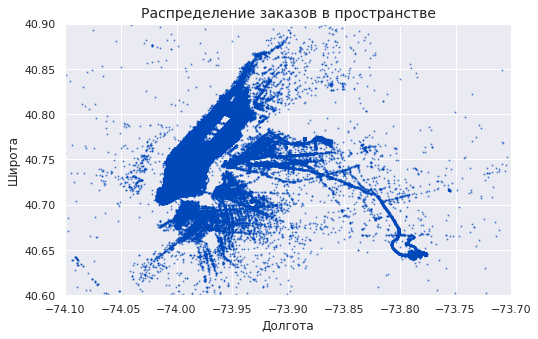

In [ ]:
plt.scatter(x = train_data.pickup_longitude, y = train_data.pickup_latitude, s = 1, alpha = 0.5, color = "#0048ba")
plt.xlim(city_long_borders)
plt.ylim(city_lat_borders)
plt.title("Распределение заказов в пространстве", fontsize=14)
plt.xlabel("Долгота")
plt.ylabel("Широта")
plt.show()

In [ ]:
coords = np.vstack((train_data[['pickup_latitude', 'pickup_longitude']].values,
                    train_data[['dropoff_latitude', 'dropoff_longitude']].values))

In [ ]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [ ]:
train_data["pickup_cluster"] = kmeans.predict(train_data[["pickup_latitude", "pickup_longitude"]])
train_data["dropoff_cluster"] = kmeans.predict(train_data[["dropoff_latitude", "dropoff_longitude"]])

Используя алгоритм кластеризация KMeans на подвыборке, мы получили 100 кластеров, которые можно увидеть на следующем графике.

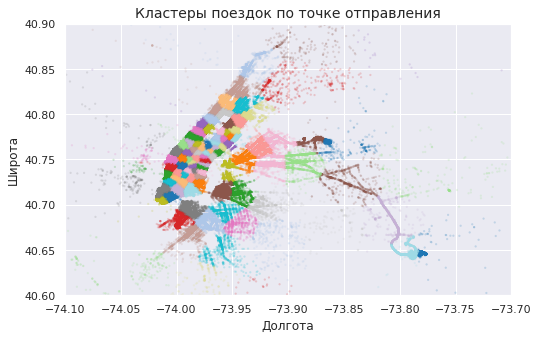

In [ ]:
plt.scatter(train_data.pickup_longitude.values, train_data.pickup_latitude.values, s=5, lw=0,
           c=train_data.pickup_cluster.values, cmap="tab20", alpha=0.2)
plt.xlim(city_long_borders)
plt.ylim(city_lat_borders)
plt.title("Кластеры поездок по точке отправления", fontsize=14)
plt.xlabel("Долгота")
plt.ylabel("Широта")
plt.show()

#### 2.5. Данные о погоде 

Добавим данные о погоде в Нью-Йорке, которые были взяты из https://www.kaggle.com/datasets/mathijs/weather-data-in-new-york-city-2016

In [ ]:
weather_data = pd.read_csv("/content/gdrive/My Drive/Taxi_duration_prediction/weather_data_nyc_centralpark_2016(1).csv")

In [ ]:
weather_data.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38.0,0.00,0.0,0
1,2-1-2016,40,32,36.0,0.00,0.0,0
2,3-1-2016,45,35,40.0,0.00,0.0,0
3,4-1-2016,36,14,25.0,0.00,0.0,0
4,5-1-2016,29,11,20.0,0.00,0.0,0


In [ ]:
weather_data.columns = [column.replace(" ", "_") for column in weather_data.columns]

In [ ]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 366 non-null    object 
 1   maximum_temperature  366 non-null    int64  
 2   minimum_temperature  366 non-null    int64  
 3   average_temperature  366 non-null    float64
 4   precipitation        366 non-null    object 
 5   snow_fall            366 non-null    object 
 6   snow_depth           366 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 20.1+ KB


In [ ]:
weather_data.precipitation.unique()

array(['0.00', 'T', '1.80', '0.24', '0.05', '0.01', '2.31', '0.73',
       '0.53', '0.44', '1.01', '0.03', '0.30', '1.22', '0.02', '0.14',
       '0.11', '0.06', '0.29', '0.07', '0.04', '0.38', '0.16', '0.09',
       '0.47', '0.20', '0.61', '0.54', '0.25', '0.18', '1.65', '0.40',
       '0.91', '0.45', '0.22', '0.12', '0.83', '0', '0.49', '0.66',
       '0.08', '0.62', '0.35', '1', '1.09', '1.08', '0.15', '0.32',
       '0.82', '0.31', '0.5', '0.56', '0.68', '0.2', '0.4', '0.23',
       '0.55', '1.11', '1.41', '1.81', '2.2', '0.19', '0.39'],
      dtype=object)

In [ ]:
weather_data.snow_fall.unique()

array(['0.0', 'T', '0.4', '0.2', '27.3', '2.5', '0.1', '1.4', '0.5', '0',
       '2.8'], dtype=object)

In [ ]:
weather_data.snow_depth.unique()

array(['0', 'T', '6', '22', '19', '17', '9', '4', '2', '1'], dtype=object)

In [ ]:
weather_data.loc[weather_data["precipitation"] == "T", "precipitation"] = 0
weather_data["precipitation"] = weather_data["precipitation"].astype(float)

weather_data.loc[weather_data["snow_fall"] == "T", "snow_fall"] = 0
weather_data["snow_fall"] = weather_data["snow_fall"].astype(float)

weather_data.loc[weather_data["snow_depth"] == "T", "snow_depth"] = 0
weather_data["snow_depth"] = weather_data["snow_depth"].astype(float)

In [ ]:
weather_data["date"] = weather_data["date"].apply(lambda x: datetime.strptime(str(x), '%d-%m-%Y').date())

In [ ]:
train_data = pd.merge(train_data, weather_data, how = "left", left_on = "pickup_date", right_on = "date")

#### 2.6. Преобразование категориальных переменных

Создадим дамми-переменные на основе категориальных. 

In [ ]:
vendor_train_data = pd.get_dummies(train_data["vendor_id"], prefix = "ven", prefix_sep = "_")
passenger_count_train_data = pd.get_dummies(train_data["passenger_count"], prefix = "pc", prefix_sep = "_")
store_and_fwd_flag_train_data = pd.get_dummies(train_data["store_and_fwd_flag"], prefix = "sff", prefix_sep = "_")
pickup_day_train_data = pd.get_dummies(train_data["pickup_day"], prefix = "day", prefix_sep = "_")
pickup_month_train_data = pd.get_dummies(train_data["pickup_month"], prefix = "month", prefix_sep = "_")
pickup_weekday_train_data = pd.get_dummies(train_data["pickup_weekday"], prefix = "weekday", prefix_sep = "_")
pickup_hour_train_data = pd.get_dummies(train_data["pickup_hour"], prefix = "hour", prefix_sep = "_")
pickup_cluster_train_data = pd.get_dummies(train_data["pickup_cluster"], prefix = "cls_pickup", prefix_sep = "_")
dropoff_cluster_train_data = pd.get_dummies(train_data["dropoff_cluster"], prefix = "cls_dropoff", prefix_sep = "_")

In [ ]:
train_data_drpd = train_data.drop(["id","vendor_id", "pickup_datetime", "dropoff_datetime",
                                   "passenger_count", "pickup_longitude","pickup_latitude", "date_x", 
                         "dropoff_longitude","dropoff_latitude", "store_and_fwd_flag", 
                         "holiday_date", "pickup_date", "pickup_day", "pickup_month", "pickup_weekday", 
                                   "pickup_hour", "pickup_cluster", "dropoff_cluster",
                                  "date_y", "maximum_temperature", "minimum_temperature"],axis = 1)

In [ ]:
train = pd.concat([train_data_drpd, vendor_train_data, passenger_count_train_data, store_and_fwd_flag_train_data,
                  pickup_day_train_data, pickup_month_train_data, pickup_weekday_train_data, pickup_hour_train_data, 
                  pickup_cluster_train_data, dropoff_cluster_train_data], axis = 1)

In [ ]:
#y = train_data["trip_duration"]

### 3. Анализ и предобработка данных тестовой выборки 

In [ ]:
test_data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


Проанализируем, насколько данные тестовой выборки соотносятся с данными тренировочной выборки. 

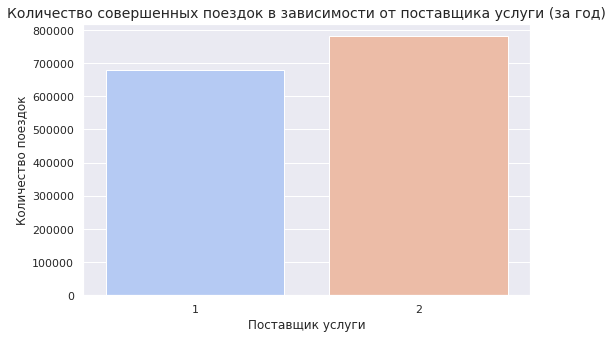

In [ ]:
sns.countplot(x = train_data.vendor_id, palette = "coolwarm")
plt.title("Количество совершенных поездок в зависимости от поставщика услуги (за год)", fontsize=14)
plt.xlabel("Поставщик услуги")
plt.ylabel("Количество поездок")
plt.show()

Соотношение количества поездок от разных поставщиков услуг в тестовой выборке примерно такое же как и в тренировочной выборке.

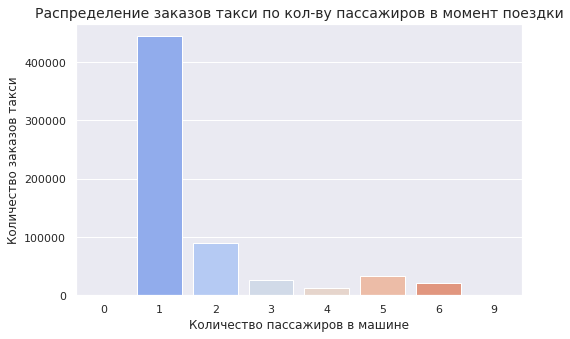

In [ ]:
sns.countplot(x = test_data.passenger_count, palette = "coolwarm")
plt.title("Распределение заказов такси по кол-ву пассажиров в момент поездки", fontsize=14)
plt.xlabel("Количество пассажиров в машине")
plt.ylabel("Количество заказов такси")
plt.show()

Как и в тренировочной выборке, в тестовой выборке большинство поездок были совершены с количеством пассажиров, равным 1 или 2 человек. Однако в тестовой выборке нет поездок с количеством пассажиров 7 и 8 человек.

In [ ]:
test_data["date"] = test_data["pickup_datetime"].apply(lambda x: datetime.strptime(x[:10], '%Y-%m-%d'))

In [ ]:
test_data["holiday_date"] = test_data["date"].isin(holidays)
test_data["holiday_date"] = test_data["holiday_date"].map(lambda x: 1 if x == True else 0)

In [ ]:
test_data["pickup_datetime"] = pd.to_datetime(test_data["pickup_datetime"])

test_data["pickup_date"] = test_data["pickup_datetime"].dt.date
test_data["pickup_day"] = test_data["pickup_datetime"].dt.day
test_data["pickup_month"] = test_data["pickup_datetime"].dt.month
test_data["pickup_weekday"] = test_data["pickup_datetime"].dt.weekday
test_data["pickup_hour"] = test_data["pickup_datetime"].dt.hour

In [ ]:
number_trips_by_vendor_test = test_data.groupby(["pickup_date", "vendor_id"])["pickup_datetime"].count().reset_index()\
                            .rename(columns = {"pickup_datetime": "trips_count"})

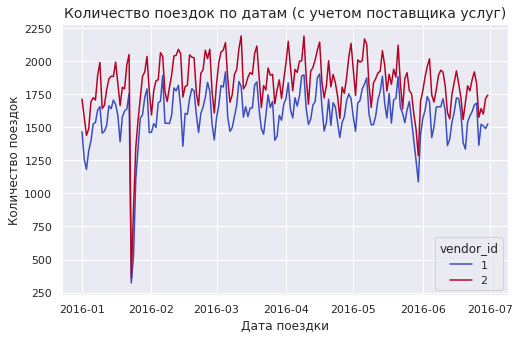

In [ ]:
sns.lineplot(x = number_trips_by_vendor_test.pickup_date,
             y = number_trips_by_vendor_test.trips_count, 
             hue = number_trips_by_vendor_test.vendor_id,
            palette = "coolwarm")
plt.xlabel("Дата поездки")
plt.ylabel("Количество поездок")
plt.title("Количество поездок по датам (с учетом поставщика услуг)", fontsize = 14)
plt.show()

Распределение количества поездок по датам похоже распределение в тренировочной выборке. 

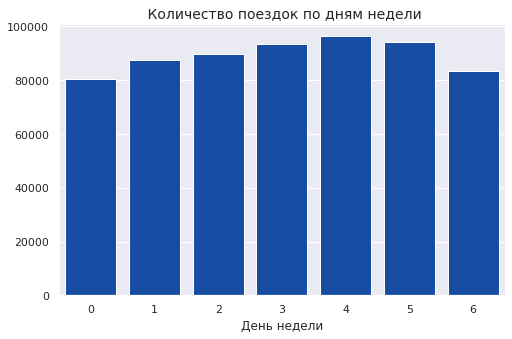

In [ ]:
sns.barplot(x = test_data.groupby("pickup_weekday")["vendor_id"].count().index, 
            y = test_data.groupby("pickup_weekday")["vendor_id"].count().values,
            color = "#0048ba")
plt.title(" Количество поездок по дням недели", fontsize=14)
plt.xlabel("День недели")
plt.show()

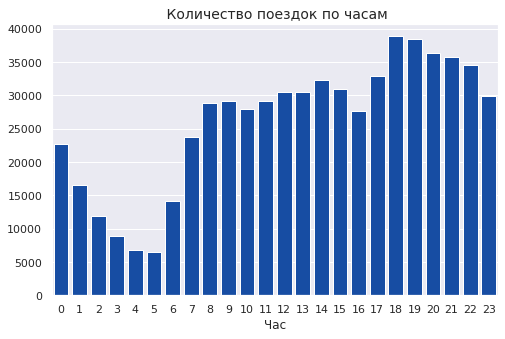

In [ ]:
sns.barplot(x = test_data.groupby("pickup_hour")["vendor_id"].count().index, 
            y = test_data.groupby("pickup_hour")["vendor_id"].count().values,
            color = "#0048ba")
plt.title(" Количество поездок по часам", fontsize=14)
plt.xlabel("Час")
plt.show()

Распределения количества поездок по дням недели и часам так же похоже на соответсвующие распределения в тренировочной выборке.

Рассчитаем расстояние поездки (гаверсинус и манхеттоновское) для каждого наблюдения в тестовой выборке. 

In [ ]:
test_data["haversine_distance"] = haversine_distance(test_data["pickup_latitude"].values, 
                                                     test_data["pickup_longitude"].values, 
                                                     test_data["dropoff_latitude"].values, 
                                                     test_data["dropoff_longitude"].values)

test_data["manhattan_distance"] =  manhattan_distance(test_data["pickup_latitude"].values, 
                                                                   test_data["pickup_longitude"].values, 
                                                                   test_data["dropoff_latitude"].values, 
                                                                   test_data["dropoff_longitude"].values)

test_data["direction"] = bearing(test_data["pickup_latitude"].values, 
                                        test_data["pickup_longitude"].values, 
                                        test_data["dropoff_latitude"].values, 
                                        test_data["dropoff_longitude"].values)

Посмотрим на распределение точек отправления такси на карте с помощью диаграммы рассеяния. 

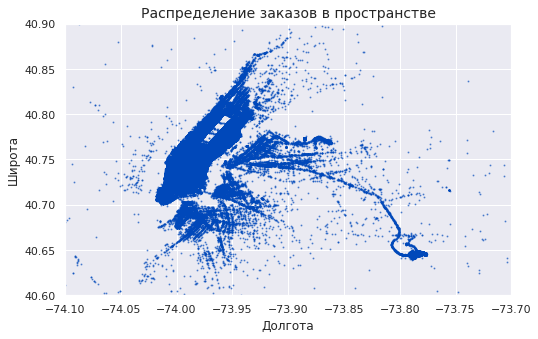

In [ ]:
plt.scatter(x = test_data.pickup_longitude, y = test_data.pickup_latitude, s = 1, alpha = 0.5, color = "#0048ba")
plt.xlim(city_long_borders)
plt.ylim(city_lat_borders)
plt.title("Распределение заказов в пространстве", fontsize=14)
plt.xlabel("Долгота")
plt.ylabel("Широта")
plt.show()

Создадим переменные, обозначающие районы отправления и прибытия такси.

In [ ]:
test_data["pickup_cluster"] = kmeans.predict(test_data[["pickup_latitude", "pickup_longitude"]])
test_data["dropoff_cluster"] = kmeans.predict(test_data[["dropoff_latitude", "dropoff_longitude"]])

Посмотрим на получившиеся кластеры. 

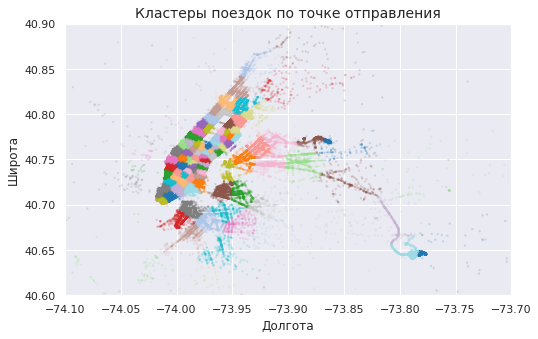

In [ ]:
plt.scatter(test_data.pickup_longitude.values, test_data.pickup_latitude.values, s=5, lw=0,
           c=test_data.pickup_cluster.values, cmap="tab20", alpha=0.2)
plt.xlim(city_long_borders)
plt.ylim(city_lat_borders)
plt.title("Кластеры поездок по точке отправления", fontsize=14)
plt.xlabel("Долгота")
plt.ylabel("Широта")
plt.show()

Создадим дамми-переменные на основе категориальных. 

In [ ]:
vendor_test_data = pd.get_dummies(test_data["vendor_id"], prefix = "ven", prefix_sep = "_")
passenger_count_test_data = pd.get_dummies(test_data["passenger_count"], prefix = "pc", prefix_sep = "_")
store_and_fwd_flag_test_data = pd.get_dummies(test_data["store_and_fwd_flag"], prefix = "sff", prefix_sep = "_")
pickup_day_test_data = pd.get_dummies(test_data["pickup_day"], prefix = "day", prefix_sep = "_")
pickup_month_test_data = pd.get_dummies(test_data["pickup_month"], prefix = "month", prefix_sep = "_")
pickup_weekday_test_data = pd.get_dummies(test_data["pickup_weekday"], prefix = "weekday", prefix_sep = "_")
pickup_hour_test_data = pd.get_dummies(test_data["pickup_hour"], prefix = "hour", prefix_sep = "_")
pickup_cluster_test_data = pd.get_dummies(test_data["pickup_cluster"], prefix = "cls_pickup", prefix_sep = "_")
dropoff_cluster_test_data = pd.get_dummies(test_data["dropoff_cluster"], prefix = "cls_dropoff", prefix_sep = "_")

Добавляем информацию о погоде.

In [ ]:
test_data = pd.merge(test_data, weather_data, how = "left", left_on = "pickup_date", right_on = "date")

In [ ]:
test_data_drpd = test_data.drop(["id","vendor_id", "pickup_datetime",
                                   "passenger_count", "pickup_longitude","pickup_latitude", "date_x", 
                         "dropoff_longitude", "dropoff_latitude", "store_and_fwd_flag",  
                         "holiday_date", "pickup_date", "pickup_day", "pickup_month", "pickup_weekday", 
                                   "pickup_hour", "pickup_cluster", "dropoff_cluster",
                                  "date_y", "maximum_temperature", "minimum_temperature"],axis = 1)

In [ ]:
test = pd.concat([test_data_drpd, vendor_test_data, passenger_count_test_data, store_and_fwd_flag_test_data,
                  pickup_day_test_data, pickup_month_test_data, pickup_weekday_test_data, pickup_hour_test_data, 
                  pickup_cluster_test_data, dropoff_cluster_test_data], axis = 1)

Проверим, совпадает ли количество переменных в тренировочной и тестовой выборке после всех преобразований.

In [ ]:
train.shape, test.shape

((1458644, 290), (625134, 287))

В тренировочной выборке оказалось на 2 переменных больше, чем в тестовой. Проанализируем, откуда взялись две лишние переменные.

In [ ]:
vendor_train_data.shape, vendor_test_data.shape

((1458644, 2), (625134, 2))

In [ ]:
passenger_count_train_data.shape, passenger_count_test_data.shape

((1458644, 10), (625134, 8))

In [ ]:
passenger_count_train_data.columns

Index(['pc_0', 'pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5', 'pc_6', 'pc_7', 'pc_8',
       'pc_9'],
      dtype='object')

In [ ]:
passenger_count_test_data.columns

Index(['pc_0', 'pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5', 'pc_6', 'pc_9'], dtype='object')

В тренировочной выборке есть случаи, в которых в машине такси находились 7 и 8 человек в момент поездки, но в тестовой выборке таких случаев нет.

In [ ]:
passenger_count_train_data.pc_7.value_counts()

0    1458641
1          3
Name: pc_7, dtype: int64

In [ ]:
passenger_count_train_data.pc_8.value_counts()

0    1458643
1          1
Name: pc_8, dtype: int64

In [ ]:
passenger_count_train_data.pc_9.value_counts()

0    1458643
1          1
Name: pc_9, dtype: int64

In [ ]:
passenger_count_test_data.pc_9.value_counts()

0    625132
1         2
Name: pc_9, dtype: int64

, ,   ,  jfjfМожно удалить наблюдения из тренировочной выборки с количеством человек в машине, равным 7 и 8, поскольку таких наблюдений всего 4. Кроме того, из тренировочной и тестовой выборок можно удалить наблюдения с 9 людьми в машине, так как таких наблюдений всего 1 в тренировочной выборке и 2 - в тестовой.

In [ ]:
train = train.drop(["pc_7", "pc_8", "pc_9"], axis = 1)
test = test.drop(["pc_9"], axis = 1)

In [ ]:
train.shape, test.shape

((1458644, 287), (625134, 286))

Теперь количество переменных в тренировочной и тестовой выборках совпадает.

### Выбор и построение моделей. Оценка качества моделей 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [ ]:
train.shape

(1458644, 287)

In [ ]:
train["trip_duration"]

0           455
1           663
2          2124
3           429
4           435
           ... 
1458639     778
1458640     655
1458641     764
1458642     373
1458643     198
Name: trip_duration, Length: 1458644, dtype: int64

In [ ]:
y = train["trip_duration"]

In [ ]:
train.drop("trip_duration", axis = 1, inplace = True)

In [ ]:
train.shape

(1458644, 286)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train, y, test_size=0.3, random_state = 42)

<AxesSubplot:>

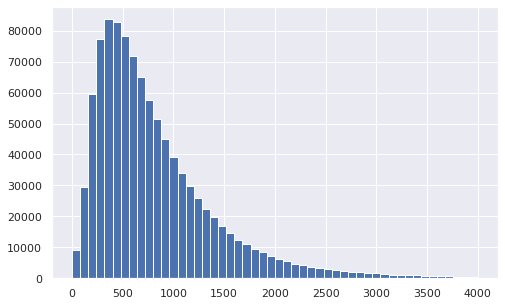

In [ ]:
pd.Series(y_train[y_train < 4000]).hist(bins=50)

<AxesSubplot:>

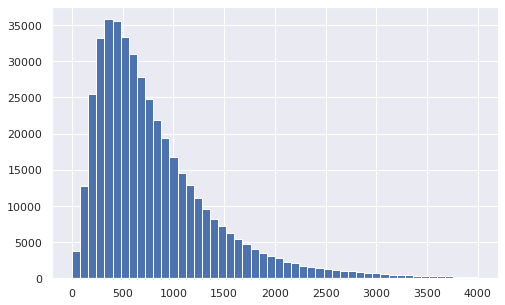

In [ ]:
pd.Series(y_valid[y_valid < 4000]).hist(bins=50)

In [ ]:
y_train_log = np.log(y_train + 1)
y_valid_log = np.log(y_valid + 1)

If you want to transform your outcome, you can:

* Train the model on the transformed outcomes
* Predict on a held out set
* Re-transform the predictions to the original space
* Evaluate the prediction quality in the original space

**Linear Regression - base model**

In [ ]:
regressor = LinearRegression()

In [ ]:
regressor.fit(X_train, y_train_log)

LinearRegression()

In [ ]:
mean_squared_error(y_valid_log, regressor.predict(X_valid), squared = False)

0.5959428223346936

**Ridge Regression**

In [ ]:
#Ridge_reg = Ridge()

In [ ]:
#params_Ridge = {
#   'alpha': np.arange(0, 1, 0.05)
#}

In [ ]:
#search_Ridge = GridSearchCV(Ridge_reg, params_Ridge, scoring = 'neg_mean_squared_error')

In [ ]:
#results_Ridge = search_Ridge.fit(X_train, y_train_log)

In [ ]:
#results_Ridge.best_params_

In [ ]:
best_Ridge = Ridge(alpha=0.95)

In [ ]:
best_Ridge.fit(X_train, y_train_log)

Ridge(alpha=0.95)

In [ ]:
mean_squared_error(y_valid_log, best_Ridge.predict(X_valid), squared = False)

0.5959436381548012

**Random Forest**

In [ ]:
#rfg = RandomForestRegressor()

In [ ]:
# params_rfg = { 'n_estimators': [20, 50],
#  'max_depth': [int(x) for x in np.linspace(10, 100, num = 10)],
#  'min_samples_split': [2, 5, 10],
#  'min_samples_leaf': [1, 2, 4], 
#  'max_features': [96]
#  }

In [ ]:
#search_rfg = GridSearchCV(rfg, params_rfg, cv=3, scoring = 'neg_mean_squared_error', n_jobs = -1)

In [ ]:
#results_rfg = search_rfg.fit(X_train, y_train_log)

In [ ]:
#results_rfg.best_params_

In [ ]:
 best_rfg = RandomForestRegressor(max_depth = 70,
 max_features = 96,
 min_samples_leaf = 1,
 min_samples_split = 10,
 n_estimators = 50)

In [ ]:
best_rfg.fit(X_train, y_train_log)

RandomForestRegressor(max_depth=70, max_features=96, min_samples_split=10,
                      n_estimators=50)

In [ ]:
mean_squared_error(y_valid_log, best_rfg.predict(X_valid), squared = False)

0.4116039531246907

In [ ]:
col_names = train.columns
fi_best_rfg = pd.DataFrame(best_rfg.feature_importances_, index=col_names, columns=["Importance"])

fi_best_rfg.sort_values("Importance", ascending=False).head(10)

,Importance
haversine_distance,0.358814
manhattan_distance,0.310633
direction,0.058738
average_temperature,0.013427
cls_pickup_1,0.006175
cls_pickup_96,0.005895
weekday_6,0.005802
hour_6,0.005759
precipitation,0.005021
weekday_5,0.003928


**XGBoost**

In [ ]:
import optuna

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train_log)
dvalid = xgb.DMatrix(X_valid, label=y_valid_log)
dtest = xgb.DMatrix(test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [ ]:
# def objective(trial):

#   param_grid = {
#         "max_depth": trial.suggest_int("max_depth", 3, 8, step=1),
#         "min_child_weight": trial.suggest_int("min_child_weight", 5, 8, step=1), 
#         "eta": trial.suggest_float("eta", 0.4, 0.7, step=0.1),
#         "subsample": trial.suggest_float("subsample", 0.5, 1., step=0.2),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1., step=0.2)
#     }
    
#   pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")
#   bst = xgb.train(param_grid, dtrain, evals=[(dvalid, "validation")], callbacks=[pruning_callback])
#   preds = bst.predict(dvalid)
#   pred_labels = np.rint(preds)
#   RMSE = mean_squared_error(y_valid_log, pred_labels, squared = False)
    
#   return RMSE

In [ ]:
# study = optuna.create_study(direction="minimize", study_name="XGB")

In [ ]:
# study.optimize(objective, n_trials=100)
# print(study.best_trial)

In [ ]:
xgb_best_params = {
    
    'max_depth':8,
    'min_child_weight': 5,
    'eta':0.7,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'objective':'reg:linear',
}

In [ ]:
xgb_best = xgb.train(xgb_best_params, dtrain, 50, watchlist, early_stopping_rounds=2,
      maximize=False, verbose_eval=2)

[19:00:47] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:1.86555	valid-rmse:1.86655
[2]	train-rmse:0.48560	valid-rmse:0.48735
[4]	train-rmse:0.44287	valid-rmse:0.44574
[6]	train-rmse:0.43145	valid-rmse:0.43547
[8]	train-rmse:0.42602	valid-rmse:0.43091
[10]	train-rmse:0.42165	valid-rmse:0.42777
[12]	train-rmse:0.41758	valid-rmse:0.42479
[14]	train-rmse:0.41461	valid-rmse:0.42263
[16]	train-rmse:0.41102	valid-rmse:0.42032
[18]	train-rmse:0.40817	valid-rmse:0.41875
[20]	train-rmse:0.40596	valid-rmse:0.41778
[22]	train-rmse:0.40345	valid-rmse:0.41653
[24]	train-rmse:0.40129	valid-rmse:0.41563
[26]	train-rmse:0.39993	valid-rmse:0.41512
[28]	train-rmse:0.39848	valid-rmse:0.41450
[30]	train-rmse:0.39664	valid-rmse:0.41392
[32]	train-rmse:0.39559	valid-rmse:0.41355
[34]	train-rmse:0.39384	valid-rmse:0.41273
[36]	train-rmse:0.39232	valid-rmse:0.41244
[38]	train-rmse:0.39123	valid-rmse:0.41230
[40]	train-rmse:0.38975	va

In [ ]:
mean_squared_error(y_valid_log, xgb_best.predict(dvalid), squared = False)

0.41100734704364567

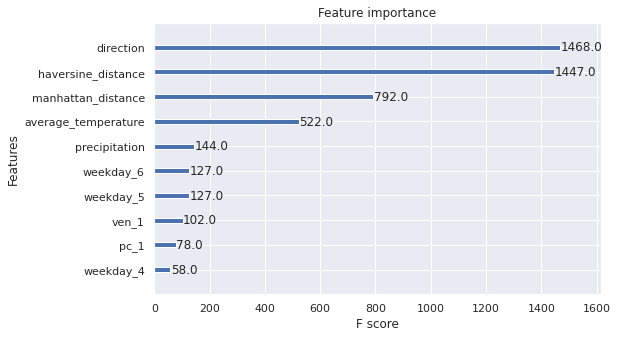

In [ ]:
from xgboost import plot_importance
plot_importance(xgb_best, max_num_features=10) # top 10 most important features
plt.show()